# Business Problem

## Business Situation

All in One Co. is a multibrand outlet that wants to create a loyality program the best customers called INSIDERS. The company has registered one year of purchasing from its customers and wants to reward those customers with marketing actions. 

Business Questions:
- Who are the customers elegible?
- How many customers will be part of Insiders group?
- What are the main behaviour of those customers?
- How much revenue comes from Insiders customer groups?
- How much revenue is expected from Insiders next month?
- Which conditions one person must comply to be an Insider?
- What removes a customer from Insider group?
- What guarantees the loyality program customers are better than others?
- Which actions MKT team could take to increase revenue?

## Business Understanding & Solution Planning

A) <u>Business problem (open question)</u> - **How could we identify customers to a loyality program?**

B) <u>Business understanding</u>

- **Motivation?** The company wants to identify the most valuable customers in order to promote a loyality program and increase engagement/purchasing from those customers. MKT team wants to address some initiatives to increase revenue from this valuable group. Thus, was requested to Data team to evaluate current purchasing data  and propose tools to help the company build the Insiders program. 

- **Root cause**: Increase revenue

- **Scope**: (closed affirmation): 
  - Firstly: Build a tool to help identify most valuable customers from actual (one year) purchasing database
  - Secondarily: Build a report to answer some business questions and support MKT initiatives. 
  
    
- **Stakeholder**? CFO


- **Acceptance Criteria**: ??

### Planning Solution

**Solution overview**:

 - <u>Kind of problem</u>: Most valuable customers identification in order to frame into loyality program
 - <u>Potential methods</u>: Clustering

#### Inputs

- Business Problem, i.e, identify most valuable customers in order to create a new loyality program and increase revenue through marketing actions
- Products sales data from Nov 2015 to Dec 2017
- Tools: 
    - Python
    - Jupyter Nb
    - Pandas, Seaborn, Sklearn, etc

#### Outputs

- Provide a list of customers that will be part of Insiders Loyality Program:


    - List format:
            client_id | is_insider:
            234213213 | no  / 0
            324325252 | yes / 1
            435345353 | yes / 1
            
            
- Report answering business questions:


    - 1. Who are the customers elegible?
    - 2. How many customers will be part of Insiders group?
    - 3. What are the main behaviour of those customers?
    - 4. How much revenue comes from Insiders customer groups?
    - 5. How much revenue is expected from Insiders next month?
    - 6. Which conditions one person must comply to be an Insider?
    - 7. What removes a customer from Insider group?
    - 8. What guarantees the loyality program customers are better than others?
    - 9. Which actions MKT team could take to increase revenue?

#### Tasks

- 1. Who are the customers elegible?

    - Who is most valuable customers? => Must be evaluated with business experts
        - Revenue:
            - High ticket?
            - High LTV?
            - High frequency?
            - High basket size?
            - Low churn?
        - Cost:
            - Low return rate?
            - Low CAC?
            
        - Experience:
            - High xp evaluation?
            
- 2. How many customers will be part of Insiders group?
        - Total of customers
        - % Insiders
        
- 3. What are the main behaviour of those customers?
        - Stratify customers characteristics and consumptions habits -> clustering features
        
- 4. How much revenue comes from Insiders customer groups?
        - Total revenue
        - Revenue from insiders
        
- 5. How much revenue is expected from Insiders next month?
        - LTV Insiders group
        - Cohort analysis (time, product, etc) 
        
- 6. Which conditions one person must comply to be an Insider?
        - Person must obbey clustering parameters
        - Retrain clustering to identify (1, 3 months)


- 7. What removes a customer from Insider group?
        - Persons that don't follow clustering parameters will be excluded
        - Retrain clustering to identify (1, 3 months)

- 8. What guarantees the loyality program customers are better than others?
        - A/B testing

- 9. Which actions MKT team could take to increase revenue?
        - Special offers, purchasing preference, free shipment, etc
        


#### Solution Benchmarks 

**Desk Research**
- RFM model (Recency, Frequency, Monetary) => MVP
    - Step1: Pick one scope and order customers
    - Step2: Split and rank (R-Score, F-Score, M-Score) the customers according to levels (ex: Lvl 1-5, 20% of customer in each level)
    - Step3: Calculate mean from R-Score, F-Score, M-Score and order
    - See RFM Segmentation and strategies to engage customers

## Project Assumptions

- invoice_no with letter 'C' will be considered returned goods
- Text in stock_code will be dropped
- Prices below 0.04 will considered as error
- Records with empty customer_id will be filled by new generated customer_ids

## Others

C) Insights


D) Business Results


E) Conclusion (Objectives reached? Problems faced?)


F) Next Steps

G) Lessons learned

# 0. Imports

In [98]:
import pandas as pd
import seaborn as sns
import numpy as np
import inflection
import re
import umap.umap_ as umap
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from matplotlib import cm
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster import hierarchy
from sklearn.ensemble import RandomForestRegressor
from plotly import express as px
from pandas_profiling import ProfileReport

SEED = 42

## 0.1 Helper Functions

In [99]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline

def plot_sillhouete_n_clusters(data, model_param, model_name, list_n_clusters):

    fig,ax = plt.subplots(int(len(list_n_clusters)/2), 2)
    fig.set_size_inches(15,15)
    
    for k in list_n_clusters:
        
        q, mod = divmod(k,2)
        
        # Perform clustering
        model = model_param(n_clusters=k).fit(data)

        # Compute the silhouette scores for each sample
        silhouette_vals = metrics.silhouette_samples(data, model.labels_)

        # Create a subplot for each cluster
        y_lower = 10

        for i in range(k):
            
            # Aggregate the silhouette scores for samples in the current cluster
            ith_cluster_silhouette_vals = silhouette_vals[model.labels_ == i]
            ith_cluster_silhouette_vals.sort()

            # Size of the current cluster
            size_cluster_i = ith_cluster_silhouette_vals.shape[0]
            y_upper = y_lower + size_cluster_i

            # Color for the current cluster
            color = cm.nipy_spectral(float(i) / k)

            # Plot the silhouette scores for the current cluster
            ax[q-1,mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_vals,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers
            ax[q-1,mod].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10
            
             # Set the limits, labels and title of the silhouette plot
            ax[q-1,mod].set_xlim([-0.2, 1])
            ax[q-1,mod].set_ylim([0, len(data) + (k + 1) * 10])
            ax[q-1,mod].set_xlabel("Silhouette score")
            ax[q-1,mod].set_ylabel("Cluster label")
            ax[q-1,mod].set_title("Silhouette analysis for {} clustering with {} clusters".format(model_name, k))

## 0.2 Loading Data

In [100]:
#load data
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding = "ISO-8859-1")
#drop undesired column
df_raw = df_raw.drop(columns='Unnamed: 8')

In [101]:
df_raw

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,7-Dec-17,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,7-Dec-17,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,7-Dec-17,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,7-Dec-17,4.15,12680.0,France


# 1. Data Description

In [102]:
df1 = df_raw.copy()

## 1.0 Rename Columns

In [103]:
#transforming to columns to snake_case 
new_cols=[]

for col in df1.columns:
    new_cols.append(inflection.underscore(col))  
    
df1.columns = new_cols 

## 1.1 Data Dimensions

In [104]:
print('The dataset has {} rows'.format(df1.shape[0]))
print('The dataset has {} attributes'.format(df1.shape[1]))

The dataset has 541909 rows
The dataset has 8 attributes


Ok, Pandas is capable to deal with this data volume

## 1.2 Check NAs

In [105]:
df1.isna().sum()*100 / df1.shape[0]

invoice_no       0.000000
stock_code       0.000000
description      0.268311
quantity         0.000000
invoice_date     0.000000
unit_price       0.000000
customer_id     24.926694
country          0.000000
dtype: float64

### 1.2.1 Adjust NAs

In [106]:
#customer_id missing values will be replaced by sequential generated id
df1['customer_id'].max()

18287.0

In [107]:
#getting unique invoice_no to missing customer_id 
df_missing = df1[df1['customer_id'].isna()].drop_duplicates(subset='invoice_no')

#setting new customer_id's
df_missing['new_customer_id'] = np.arange(19000, 19000+len(df_missing),1)

#combining back new ids
df1 = pd.merge(df1, df_missing[['invoice_no','new_customer_id']], on='invoice_no', how='left')
df1['customer_id'] = df1['customer_id'].combine_first(df1['new_customer_id'])

#dropping derived column
df1 = df1.drop(columns='new_customer_id')

In [108]:
df1.isna().sum() *100  / df1.shape[0]

invoice_no      0.000000
stock_code      0.000000
description     0.268311
quantity        0.000000
invoice_date    0.000000
unit_price      0.000000
customer_id     0.000000
country         0.000000
dtype: float64

## 1.3 Data Types

In [109]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

- invoice_no / stock_code contains letters in its composition => mantain object
- customer_id => adjust to int
- invoice_date => adjust to datetime

### 1.3.1 Adjust Data Types

In [110]:
#invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

#customer_id
df1['customer_id'] = df1['customer_id'].astype('int')

In [111]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [112]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int32
country                 object
dtype: object

# 2. Descriptive Statistics

In [113]:
df2 = df1.copy()

### 2.1 Numerical Attributes

In [114]:
num_att = df2.select_dtypes(include=['int32','int64','float64'])

In [115]:
num_att.agg(["min","max","mean","median","std","skew","kurtosis"]).T.reset_index().rename(columns= {'index' : 'features'})

,features,min,max,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,9.552250,3.00,218.081158,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,4.611114,2.08,96.759853,186.506972,59005.719097
2,customer_id,12346.00,22709.0,16688.840453,16249.00,2911.411352,0.487449,-0.804287


<h2>To investigate:</h2>

- quantity: Seems some problems (<0) => maybe returned goods? => 

- unit_price == 0 => maybe offers? 

### 2.2 Categorical Attributes

In [116]:
cat_att = df2.select_dtypes(exclude=['int32','int64','float64','datetime64[ns]'])

In [117]:
cat_att.agg(['count','unique']).T.reset_index().rename(columns= {'index' : 'features'})

,features,count,unique
0,invoice_no,541909,"[536365, 536366, 536367, 536368, 536369, 53637..."
1,stock_code,541909,"[85123A, 71053, 84406B, 84029G, 84029E, 22752,..."
2,description,540455,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET..."
3,country,541909,"[United Kingdom, France, Australia, Netherland..."


<h2>To investigate:</h2>
 
- invoice_no: There are some invoices with "C" => probably return goods

- stock_code: There are some garbage (text) and some duplicated codes with letters in the end


- country: seems ok, but have 'Unspecified' category. Understand how to deal with it


# 3. Feature Filtering

In [118]:
df3 = df2.copy()

## 3.1 Check Strutural/Business Problems

In [119]:
for i in df3['country'].unique():
    print(i)

United Kingdom
France
Australia
Netherlands
Germany
Norway
EIRE
Switzerland
Spain
Poland
Portugal
Italy
Belgium
Lithuania
Japan
Iceland
Channel Islands
Denmark
Cyprus
Sweden
Austria
Israel
Finland
Bahrain
Greece
Hong Kong
Singapore
Lebanon
United Arab Emirates
Saudi Arabia
Czech Republic
Canada
Unspecified
Brazil
USA
European Community
Malta
RSA


In [120]:
for i in sorted(df3['stock_code'].unique()):
    print(i)

10002
10080
10120
10123C
10123G
10124A
10124G
10125
10133
10134
10135
11001
15030
15034
15036
15039
15044A
15044B
15044C
15044D
15056BL
15056N
15056P
15056bl
15056n
15056p
15058A
15058B
15058C
15060B
15060b
16008
16010
16011
16012
16014
16015
16016
16020C
16033
16043
16045
16046
16048
16049
16052
16053
16054
16151A
16156L
16156S
16161G
16161M
16161P
16161U
16162L
16162M
16168M
16169E
16169K
16169M
16169N
16169P
16202A
16202B
16202E
16206B
16207A
16207B
16216
16218
16219
16225
16235
16236
16237
16238
16244B
16248B
16254
16258A
16259
17001
17003
17007B
17011A
17011F
17012A
17012B
17012C
17012D
17012E
17012F
17013D
17014A
17021
17028J
17038
17084A
17084J
17084N
17084P
17084R
17090A
17090D
17091A
17091J
17096
17107D
17109D
17129F
17136A
17164B
17165D
17174
17191A
18007
18094C
18097A
18097C
18098C
18098c
20615
20616
20617
20618
20619
20622
20652
20653
20654
20655
20657
20658
20659
20661
20662
20663
20664
20665
20666
20667
20668
20669
20670
20671
20674
20675
20676
20677
20678
20679
20681
206

In [121]:
for i in df3['description'].unique():
    print(i)

WHITE HANGING HEART T-LIGHT HOLDER
WHITE METAL LANTERN
CREAM CUPID HEARTS COAT HANGER
KNITTED UNION FLAG HOT WATER BOTTLE
RED WOOLLY HOTTIE WHITE HEART.
SET 7 BABUSHKA NESTING BOXES
GLASS STAR FROSTED T-LIGHT HOLDER
HAND WARMER UNION JACK
HAND WARMER RED POLKA DOT
ASSORTED COLOUR BIRD ORNAMENT
POPPY'S PLAYHOUSE BEDROOM 
POPPY'S PLAYHOUSE KITCHEN
FELTCRAFT PRINCESS CHARLOTTE DOLL
IVORY KNITTED MUG COSY 
BOX OF 6 ASSORTED COLOUR TEASPOONS
BOX OF VINTAGE JIGSAW BLOCKS 
BOX OF VINTAGE ALPHABET BLOCKS
HOME BUILDING BLOCK WORD
LOVE BUILDING BLOCK WORD
RECIPE BOX WITH METAL HEART
DOORMAT NEW ENGLAND
JAM MAKING SET WITH JARS
RED COAT RACK PARIS FASHION
YELLOW COAT RACK PARIS FASHION
BLUE COAT RACK PARIS FASHION
BATH BUILDING BLOCK WORD
ALARM CLOCK BAKELIKE PINK
ALARM CLOCK BAKELIKE RED 
ALARM CLOCK BAKELIKE GREEN
PANDA AND BUNNIES STICKER SHEET
STARS GIFT TAPE 
INFLATABLE POLITICAL GLOBE 
VINTAGE HEADS AND TAILS CARD GAME 
SET/2 RED RETROSPOT TEA TOWELS 
ROUND SNACK BOXES SET OF4 WOODLAND 
SPA

In [122]:
#searching for only invoices starting with a letter
df3[df3['invoice_no'].apply(lambda x: re.match('^[A-Z]+', x)).notnull()].head(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
141,C536379,D,Discount,-1,2016-11-29,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2016-11-29,3.45,17548,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2016-11-29,1.65,17548,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2016-11-29,1.65,17548,United Kingdom
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2016-11-29,4.25,17897,United Kingdom


In [123]:
#searching for only invoices starting with a letter
df3[df3['stock_code'].apply(lambda x: re.match('^[a-zA-Z]+', x)).notnull()]['stock_code'].unique()

array(['POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE',
       'DCGS0076', 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm',
       'gift_0001_50', 'gift_0001_30', 'gift_0001_20', 'DCGS0055',
       'DCGS0072', 'DCGS0074', 'DCGS0069', 'DCGS0057', 'DCGSSBOY',
       'DCGSSGIRL', 'gift_0001_10', 'PADS', 'DCGS0004', 'DCGS0073',
       'DCGS0071', 'DCGS0068', 'DCGS0067', 'DCGS0066P', 'B', 'CRUK'],
      dtype=object)

In [124]:
#removing records containing garbage in stock_code
df3 = df3[~df3['stock_code'].isin(['BANK CHARGES', 'C2', 'CRUK', 'B', 'D', 'DOT', 'M', 'm', 'PADS', 'POST','AMAZONFEE','S'])]

In [125]:
#removing unit_prices below 0.04
df3 = df3[df3['unit_price'] >= 0.04]

In [126]:
#European Community and Unspecified are not countries => remove and deal later
df3 = df3[~df3.isin(['European Community','Unspecified'])]

In [127]:
#description is useless feature to this business problem => drop
df3 = df3.drop(columns='description')

In [128]:
#dealing with returned goods (quantity < 0) - split into 2 dataframes
df_returns = df3[df3['quantity'] < 0]
df_purchases = df3[df3['quantity'] > 0]

## 3.2 Check Duplicates / Low Variance

In [129]:
#country => more than 90% from UK (low variance == less information) => evaluate drop feature
df3['country'].value_counts(normalize=True).head()*100

United Kingdom    91.680597
Germany            1.696866
France             1.536228
EIRE               1.505817
Spain              0.460271
Name: country, dtype: float64

## 3.3 Check Outliers / Business Knowledge

In [130]:
#bad users
df3 = df3[~df3['customer_id'].isin([16446])]

# 4. Feature Engineering

In [131]:
df4 = df3.copy()

In [132]:
#To derivate new features we will use RFM business model
df_ref = df4['customer_id'].drop_duplicates().reset_index(drop=True)

In [133]:
# Monetary - Gross Revenue
df_purchases['gross_revenue'] = df_purchases['quantity'] * df_purchases['unit_price']
df_monetary = df_purchases[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()

df_ref = pd.merge(df_ref, df_monetary, on='customer_id',how='left')

In [134]:
#Recency - Days from last purchase (df4['invoice_date'].max() will be considered as 'today')

df_recency = df_purchases[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df4['invoice_date'].max() - df_recency['invoice_date']).dt.days

df_ref = pd.merge(df_ref, df_recency[['customer_id','recency_days']], on = 'customer_id', how='left')



In [135]:
# Qty Invoices Purchased - How  many times purchased
df_qty = df_purchases[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_qty.columns.values[1] = 'qty_invoices'

df_ref = pd.merge(df_ref, df_qty[['customer_id','qty_invoices']], on='customer_id', how='left')

In [136]:
# Qty Total Purchased - Sum of items purchased
df_qty_items = df_purchases[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index()
df_qty_items.columns.values[1] = 'qty_items_purchased'

df_ref = pd.merge(df_ref, df_qty_items[['customer_id','qty_items_purchased']], on='customer_id', how='left')

In [137]:
# Variety Products Purchased - Count of items purchased
df_variety_prods = df_purchases[['customer_id', 'stock_code']].drop_duplicates().groupby('customer_id').count().reset_index()
df_variety_prods.columns.values[1] = 'products_variety'

df_ref = pd.merge(df_ref, df_variety_prods[['customer_id','products_variety']], on='customer_id', how='left')

In [138]:
# Avg Ticket Value
df_avg_ticket = df_purchases[['gross_revenue','customer_id']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket[['customer_id','avg_ticket']], on='customer_id',how='left')

In [139]:
#Avg Recency Days => Mean time until next purchase
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=[False, True] )
df_aux['prev_customer_id'] = df_aux['customer_id'].shift()
df_aux['prev_invoice_date'] = df_aux['invoice_date'].shift()

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['prev_invoice_date'] ).days if x['customer_id'] == x['prev_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop( ['invoice_date', 'prev_customer_id', 'prev_invoice_date'], axis=1 ).dropna()


# average recency 
df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()



# merge
df_ref = pd.merge( df_ref, df_avg_recency_days[['customer_id','avg_recency_days']], on='customer_id', how='left' )

In [140]:
#Frequency
df_freq = (df_purchases[['customer_id','invoice_date','invoice_no']].drop_duplicates()
                                                                   .groupby('customer_id')
                                                                   .agg(days = ('invoice_date', lambda x: ((x.max()-x.min()).days)+1),
                                                                        ttl_purchases = ('invoice_no','count'))).reset_index()


df_freq['frequency_days'] = df_freq.apply(lambda x: x['days']/x['ttl_purchases'], axis=1) 
df_ref = pd.merge(df_ref, df_freq[['customer_id','frequency_days']], on='customer_id', how='left')

In [141]:
#Tot Items Returned
df_ttl_returns = df_returns[['customer_id','quantity']].groupby('customer_id').sum().reset_index()
df_ttl_returns.columns.values[1] = 'total_return'

df_ref = pd.merge(df_ref, df_ttl_returns, on='customer_id', how='left')
df_ref['total_return'] = df_ref['total_return']*-1
df_ref['total_return'] = df_ref['total_return'].fillna(0)

In [142]:
#Average Basket size - Avg of qty products by invoice
df_basket_size = (df_purchases[['customer_id', 'invoice_no', 'stock_code', 'quantity']].groupby('customer_id')
                                                                                 .agg(n_purchases=('invoice_no','nunique'),
                                                                                      qty_products=('quantity','sum'))
                                                                                 .reset_index())

df_basket_size['avg_basket_size'] = df_basket_size['qty_products'] / df_basket_size['n_purchases']

df_ref = pd.merge(df_ref, df_basket_size[['customer_id','avg_basket_size']], on='customer_id', how='left' )

In [143]:
#Basket size variety - avg diff products purchased
df_basket_uniq = (df_purchases[['customer_id', 'invoice_no', 'stock_code', 'quantity']].groupby('customer_id')
                                                                                 .agg(n_purchases=('invoice_no','nunique'),
                                                                                      n_products=('stock_code','nunique'))
                                                                                 .reset_index())

df_basket_uniq['avg_variety_basket'] = df_basket_uniq['n_products'] / df_basket_uniq['n_purchases']

df_ref = pd.merge(df_ref, df_basket_uniq[['customer_id','avg_variety_basket']], on='customer_id', how='left' )

In [144]:
#dropping records w/ NAs generated in feature engineering => will be investigated later
df_ref = df_ref.dropna()

In [146]:
df_ref.isna().sum()

customer_id            0
gross_revenue          0
recency_days           0
qty_invoices           0
qty_items_purchased    0
products_variety       0
avg_ticket             0
avg_recency_days       0
frequency_days         0
total_return           0
avg_basket_size        0
avg_variety_basket     0
dtype: int64

#### Feature Ideas
- Sazonality (moving average)
- LTV (Average customer lifespan x Customer Value = Avg Purchase Value x Avg Purchase Frequency)

# 5. Exploratory Data Analysis

In [147]:
#df5 = df4.copy()
df5 = df_ref.copy()

In [148]:
# profile = ProfileReport(df5)
# profile.to_file('EDA_v2.html')

## 5.1 Univariate Analysis

In [149]:
df5[df5['gross_revenue'] > 100000].sort_values('gross_revenue', ascending=False).head(10)

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items_purchased,products_variety,avg_ticket,avg_recency_days,frequency_days,total_return,avg_basket_size,avg_variety_basket
1014,14646,279138.02,1.0,72.0,196844.0,699.0,135.503893,7.673913,4.916667,288.0,2733.944444,9.708333
490,18102,259657.30,0.0,60.0,64124.0,150.0,602.453132,14.115385,6.133333,0.0,1068.733333,2.500000
432,17450,194550.79,8.0,46.0,69993.0,124.0,577.302047,11.218750,7.826087,952.0,1521.586957,2.695652
66,14911,136275.72,1.0,198.0,80179.0,1785.0,24.382845,2.565517,1.883838,3331.0,404.944444,9.015152
1147,12415,124564.53,24.0,20.0,77373.0,443.0,174.704811,18.411765,15.700000,427.0,3868.650000,22.150000
189,14156,116729.63,9.0,54.0,57872.0,713.0,84.159791,7.260000,6.722222,859.0,1071.703704,13.203704


In [150]:
df5[df5['qty_invoices'] > 50].sort_values('qty_invoices', ascending=False).head(10)

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items_purchased,products_variety,avg_ticket,avg_recency_days,frequency_days,total_return,avg_basket_size,avg_variety_basket
47,12748,32317.32,0.0,206.0,25511.0,1766.0,7.056183,3.271930,1.815534,1535.0,123.839806,8.572816
66,14911,136275.72,1.0,198.0,80179.0,1785.0,24.382845,2.565517,1.883838,3331.0,404.944444,9.015152
68,17841,40967.72,1.0,124.0,23053.0,1322.0,5.226808,3.321429,3.008065,203.0,185.911290,10.661290
277,13089,58825.83,2.0,97.0,31070.0,636.0,32.357442,4.475610,3.793814,283.0,320.309278,6.556701
8,15311,60767.90,0.0,91.0,38194.0,567.0,25.543464,4.144444,4.109890,474.0,419.714286,6.230769
96,14606,12006.65,1.0,90.0,6214.0,816.0,4.451854,4.227273,4.144444,245.0,69.044444,9.066667
182,12971,11189.91,3.0,86.0,9289.0,94.0,36.688230,5.197183,4.302326,85.0,108.011628,1.093023
1014,14646,279138.02,1.0,72.0,196844.0,699.0,135.503893,7.673913,4.916667,288.0,2733.944444,9.708333
12,16029,72882.09,38.0,62.0,40207.0,43.0,302.415311,7.613636,5.419355,8004.0,648.500000,0.693548
19,13408,28117.04,1.0,62.0,16232.0,234.0,58.822259,6.888889,6.016129,104.0,261.806452,3.774194


In [151]:
df5[df5['qty_items_purchased'] > 1500].sort_values('qty_items_purchased', ascending=False).head(10)

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items_purchased,products_variety,avg_ticket,avg_recency_days,frequency_days,total_return,avg_basket_size,avg_variety_basket
1014,14646,279138.02,1.0,72.0,196844.0,699.0,135.503893,7.673913,4.916667,288.0,2733.944444,9.708333
66,14911,136275.72,1.0,198.0,80179.0,1785.0,24.382845,2.565517,1.883838,3331.0,404.944444,9.015152
1147,12415,124564.53,24.0,20.0,77373.0,443.0,174.704811,18.411765,15.700000,427.0,3868.650000,22.150000
432,17450,194550.79,8.0,46.0,69993.0,124.0,577.302047,11.218750,7.826087,952.0,1521.586957,2.695652
15,17511,91062.38,2.0,31.0,64549.0,453.0,94.561142,11.593750,12.000000,1535.0,2082.225806,14.612903
490,18102,259657.30,0.0,60.0,64124.0,150.0,602.453132,14.115385,6.133333,0.0,1068.733333,2.500000
36,13694,65039.62,3.0,50.0,63312.0,366.0,114.506373,9.250000,7.420000,1504.0,1266.240000,7.320000
823,14298,51527.30,8.0,44.0,58343.0,884.0,31.476665,14.280000,8.022727,322.0,1325.977273,20.090909
189,14156,116729.63,9.0,54.0,57872.0,713.0,84.159791,7.260000,6.722222,859.0,1071.703704,13.203704
952,16684,66653.56,4.0,28.0,50255.0,119.0,240.626570,20.823529,12.678571,864.0,1794.821429,4.250000


In [152]:
df5[df5['products_variety'] > 1000].sort_values('products_variety', ascending=False).head(10)

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items_purchased,products_variety,avg_ticket,avg_recency_days,frequency_days,total_return,avg_basket_size,avg_variety_basket
66,14911,136275.72,1.0,198.0,80179.0,1785.0,24.382845,2.565517,1.883838,3331.0,404.944444,9.015152
47,12748,32317.32,0.0,206.0,25511.0,1766.0,7.056183,3.271930,1.815534,1535.0,123.839806,8.572816
68,17841,40967.72,1.0,124.0,23053.0,1322.0,5.226808,3.321429,3.008065,203.0,185.911290,10.661290
4393,14096,53258.43,4.0,17.0,16336.0,1118.0,10.453078,6.062500,5.764706,0.0,960.941176,65.764706


In [153]:
df5[df5['avg_ticket'] > 800].sort_values('avg_ticket', ascending=False).head(10)

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items_purchased,products_variety,avg_ticket,avg_recency_days,frequency_days,total_return,avg_basket_size,avg_variety_basket
1260,15749,44534.30,235.0,3.0,18028.0,5.0,4453.430000,97.000000,32.666667,9014.0,6009.333333,1.666667
1817,18087,3202.92,290.0,1.0,3906.0,1.0,3202.920000,67.666667,1.000000,336.0,3906.000000,1.000000
1133,16532,6748.80,17.0,3.0,2016.0,2.0,1687.200000,160.500000,107.333333,0.0,672.000000,0.666667
599,12755,3811.95,280.0,2.0,1491.0,4.0,952.987500,38.666667,43.000000,624.0,745.500000,2.000000
3248,18133,931.50,212.0,1.0,1350.0,1.0,931.500000,1.000000,1.000000,0.0,1350.000000,1.000000
3769,12798,6977.04,10.0,3.0,5256.0,6.0,872.130000,80.000000,53.666667,0.0,1752.000000,2.000000
248,17949,58030.48,1.0,44.0,30450.0,28.0,841.021449,12.333333,8.431818,2878.0,692.045455,0.636364


In [154]:
df5[df5['total_return'] > 1000].sort_values('total_return', ascending=False).head(10)

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items_purchased,products_variety,avg_ticket,avg_recency_days,frequency_days,total_return,avg_basket_size,avg_variety_basket
1260,15749,44534.30,235.0,3.0,18028.0,5.0,4453.430000,97.000000,32.666667,9014.0,6009.333333,1.666667
12,16029,72882.09,38.0,62.0,40207.0,43.0,302.415311,7.613636,5.419355,8004.0,648.500000,0.693548
967,12931,42055.96,21.0,15.0,28004.0,28.0,512.877561,24.000000,22.466667,4427.0,1866.933333,1.866667
2541,14607,15021.50,15.0,12.0,10734.0,37.0,192.583333,41.000000,20.583333,3768.0,894.500000,3.083333
66,14911,136275.72,1.0,198.0,80179.0,1785.0,24.382845,2.565517,1.883838,3331.0,404.944444,9.015152
248,17949,58030.48,1.0,44.0,30450.0,28.0,841.021449,12.333333,8.431818,2878.0,692.045455,0.636364
907,15482,11014.96,15.0,11.0,5019.0,45.0,113.556289,38.111111,31.272727,2022.0,456.272727,4.090909
264,15769,56252.72,7.0,26.0,29672.0,26.0,432.713231,15.826087,14.038462,2012.0,1141.230769,1.000000
2337,12901,17654.54,8.0,28.0,23075.0,30.0,152.194310,9.357143,9.392857,1776.0,824.107143,1.071429
247,16013,37130.60,3.0,47.0,15536.0,30.0,267.126619,11.870968,7.851064,1594.0,330.553191,0.638298


In [155]:
df5[df5['avg_basket_size'] > 2000].sort_values('avg_basket_size', ascending=False).head(10)

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items_purchased,products_variety,avg_ticket,avg_recency_days,frequency_days,total_return,avg_basket_size,avg_variety_basket
1260,15749,44534.30,235.0,3.0,18028.0,5.0,4453.430000,97.000000,32.666667,9014.0,6009.333333,1.666667
3270,12590,9341.26,211.0,1.0,4282.0,67.0,139.421791,21.000000,1.000000,4.0,4282.000000,67.000000
1817,18087,3202.92,290.0,1.0,3906.0,1.0,3202.920000,67.666667,1.000000,336.0,3906.000000,1.000000
1147,12415,124564.53,24.0,20.0,77373.0,443.0,174.704811,18.411765,15.700000,427.0,3868.650000,22.150000
1024,13027,6912.00,113.0,6.0,17280.0,6.0,265.846154,48.200000,40.333333,0.0,2880.000000,1.000000
4965,12536,4279.71,59.0,1.0,2801.0,259.0,16.523977,26.000000,1.000000,129.0,2801.000000,259.000000
1014,14646,279138.02,1.0,72.0,196844.0,699.0,135.503893,7.673913,4.916667,288.0,2733.944444,9.708333
828,17404,31781.82,4.0,13.0,32744.0,109.0,162.983692,25.428571,27.461538,424.0,2518.769231,8.384615
1720,12754,3010.74,235.0,3.0,6481.0,49.0,47.789524,36.500000,24.666667,0.0,2160.333333,16.333333
15,17511,91062.38,2.0,31.0,64549.0,453.0,94.561142,11.593750,12.000000,1535.0,2082.225806,14.612903


In [156]:
df5[df5['avg_variety_basket'] > 100].sort_values('avg_variety_basket', ascending=False).head(10)

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items_purchased,products_variety,avg_ticket,avg_recency_days,frequency_days,total_return,avg_basket_size,avg_variety_basket
4965,12536,4279.71,59.0,1.0,2801.0,259.0,16.523977,26.000000,1.000000,129.0,2801.000000,259.0
4187,16984,4481.35,88.0,2.0,2423.0,354.0,11.010688,17.333333,21.500000,15.0,1211.500000,177.0
1178,12501,2025.39,336.0,1.0,1775.0,148.0,13.685068,21.000000,1.000000,61.0,1775.000000,148.0
4867,13422,2626.30,64.0,1.0,1326.0,127.0,20.679528,13.000000,1.000000,5.0,1326.000000,127.0
1695,17337,2026.42,151.0,4.0,1268.0,420.0,3.738782,53.000000,40.000000,29.0,317.000000,105.0
5670,13521,1092.39,1.0,3.0,733.0,312.0,2.511241,4.500000,3.333333,0.0,244.333333,104.0
4945,12607,1579.51,60.0,1.0,1228.0,101.0,15.638713,2.000000,1.000000,1228.0,1228.000000,101.0


In [157]:
df_ref[df_ref['customer_id']==14646] 

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items_purchased,products_variety,avg_ticket,avg_recency_days,frequency_days,total_return,avg_basket_size,avg_variety_basket
1014,14646,279138.02,1.0,72.0,196844.0,699.0,135.503893,7.673913,4.916667,288.0,2733.944444,9.708333


In [158]:
df4[df4['customer_id']==14646] #seems ok, normal behaviour

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
37952,539491,21981,12,2016-12-18,0.29,14646,Netherlands
37953,539491,21986,12,2016-12-18,0.29,14646,Netherlands
37954,539491,22720,2,2016-12-18,4.95,14646,Netherlands
37955,539491,21931,1,2016-12-18,1.95,14646,Netherlands
37956,539491,22613,2,2016-12-18,0.85,14646,Netherlands
...,...,...,...,...,...,...,...
534958,581176,22908,96,2017-12-05,0.72,14646,Netherlands
534959,581176,22907,96,2017-12-05,0.72,14646,Netherlands
534960,581176,22029,72,2017-12-05,0.36,14646,Netherlands
534961,581176,22712,72,2017-12-05,0.36,14646,Netherlands


## To investigate:
- gross_revenue => 95th percentile = 7169.562 / Max: 279138.02 -> Many people spending little, a couple spending a lot (investigate if these 'outliers' are good to solve our business problem)
- qty_invoices => follow same pattern of gross_revenue => see if business intrinsec behaviour
- qty_items_purchased => follow same pattern of gross_revenue => see if business intrinsec behaviour
- products_variety => follow same pattern of gross_revenue => see if business intrinsec behaviour
- avg_ticket => follow same pattern of gross_revenue => see if business intrinsec behaviour
- recency_days => distribution seems ok 
- avg_recency_days => distribution seems ok
- frequency_days => distribution seems ok
- total_return => follow same pattern of gross_revenue => see if business intrinsec behaviour
- avg_basket_size => follow same pattern of gross_revenue => see if business intrinsec behaviour
- avg_variety_size => less skewed but still following gross_revenue pattern => see if business intrinsec behaviour

**Conclusion:** Seems that some extreme values are distorting statistics/distribution. Must be evaluated. 

**Actions:**
- Evaluated most possible outliers. Seems ok, except customer_id 16446 which was removed (section 3.3)


## 5.2 Bivariate Analysis

In [159]:
# df52 = df5.drop('customer_id',axis=1)
# plt.figure(figsize=(26,12))
# sns.pairplot(df52);

## To investigate:

- frequency_day has low variance

- avg_ticket has low variance

**Actions:**
Evaluate it on feature selection

## 5.3 Data Space Investigation

In [160]:
#df53 = df5.drop(columns='customer_id',axis=1)
cols_selected = ['gross_revenue','recency_days','products_variety', 'frequency_days', 'total_return']
df53 = df5[cols_selected]

In [161]:
#scaling data to change to another space
mm = MinMaxScaler()

for col in df53.columns:
    df53[col] = mm.fit_transform(df53[[col]])

In [162]:
X_emb = df53.copy()

### 5.3.1 PCA

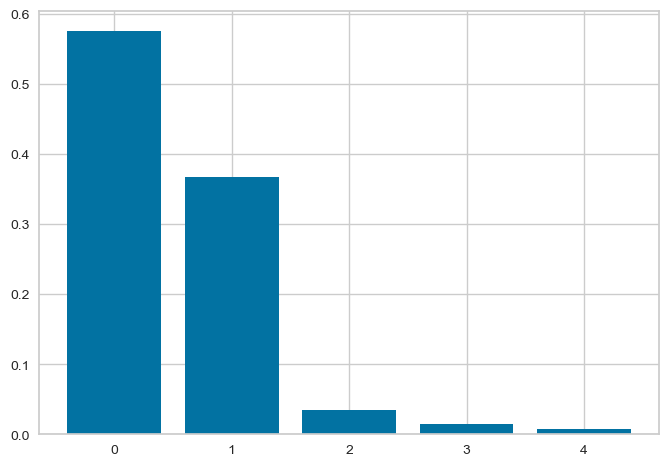

In [163]:
pca = PCA(n_components=X_emb.shape[1])
principal_components = pca.fit_transform(X_emb)

features = range(pca.n_components)

plt.bar(features, pca.explained_variance_ratio_);

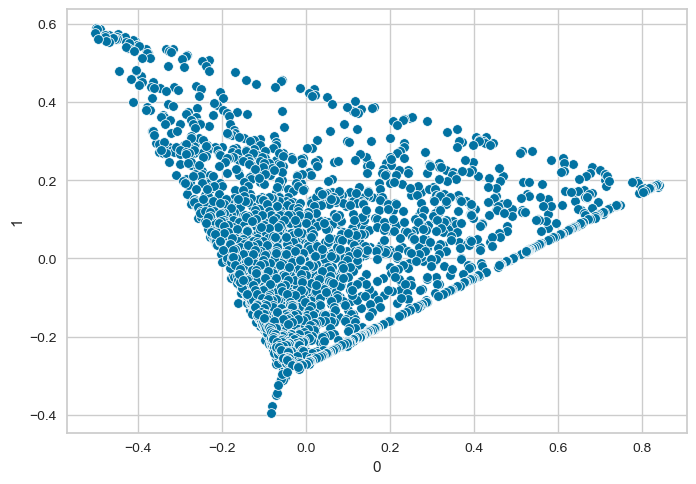

In [164]:
df_pca = pd.DataFrame(principal_components)
sns.scatterplot(x=0,y=1, data=df_pca);

### 5.3.2 UMAP

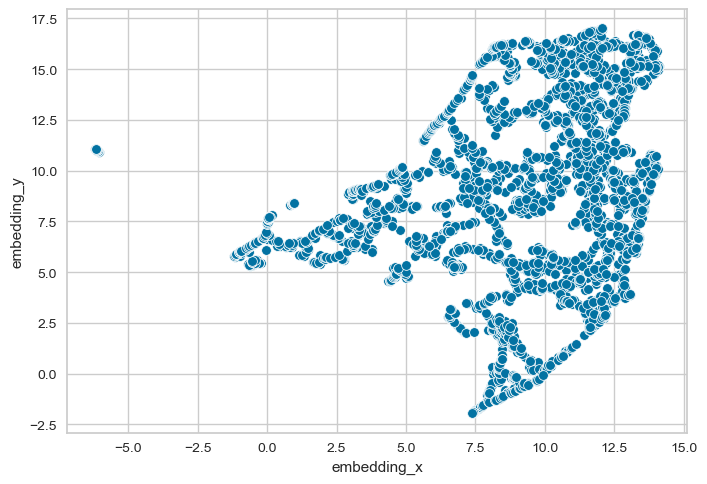

In [165]:
#instantiate a space reducer
reducer = umap.UMAP(random_state=SEED)

#create a embedding space
embedding = reducer.fit_transform(X_emb)

df_umap = pd.DataFrame(embedding, columns=['embedding_x','embedding_y'])


#plot high dimensional space into 2d 
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_umap);

### 5.3.3 t-SNE

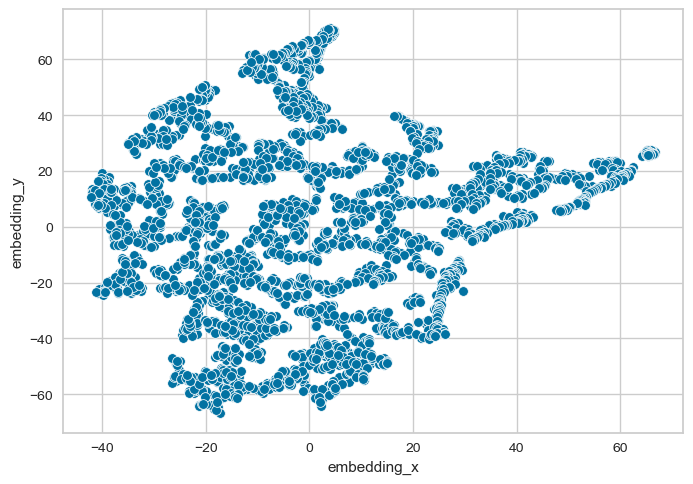

In [166]:
#instantiate a space reducer
reducer = TSNE(n_components=2, random_state=SEED, n_jobs=-1)

#create a embedding space
embedding = reducer.fit_transform(X_emb)

df_tsne = pd.DataFrame(embedding, columns=['embedding_x','embedding_y'])

#plot high dimensional space into 2d 
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tsne);

### 5.3.4 Tree Based Embedding

In [167]:
# X_emb = df5.drop(columns=['customer_id','gross_revenue'], axis=1)
# y = df5['gross_revenue'] 

cols_selected_tree = ['recency_days','products_variety', 'frequency_days', 'total_return']
X_emb = df5[cols_selected_tree]
y = df5['gross_revenue']

# model definition
rf = RandomForestRegressor(n_estimators=100, random_state=SEED)

# model training
rf.fit(X_emb,y)

# dataframe leaves - tree-based embedding
df_leaf = pd.DataFrame(rf.apply(X_emb))

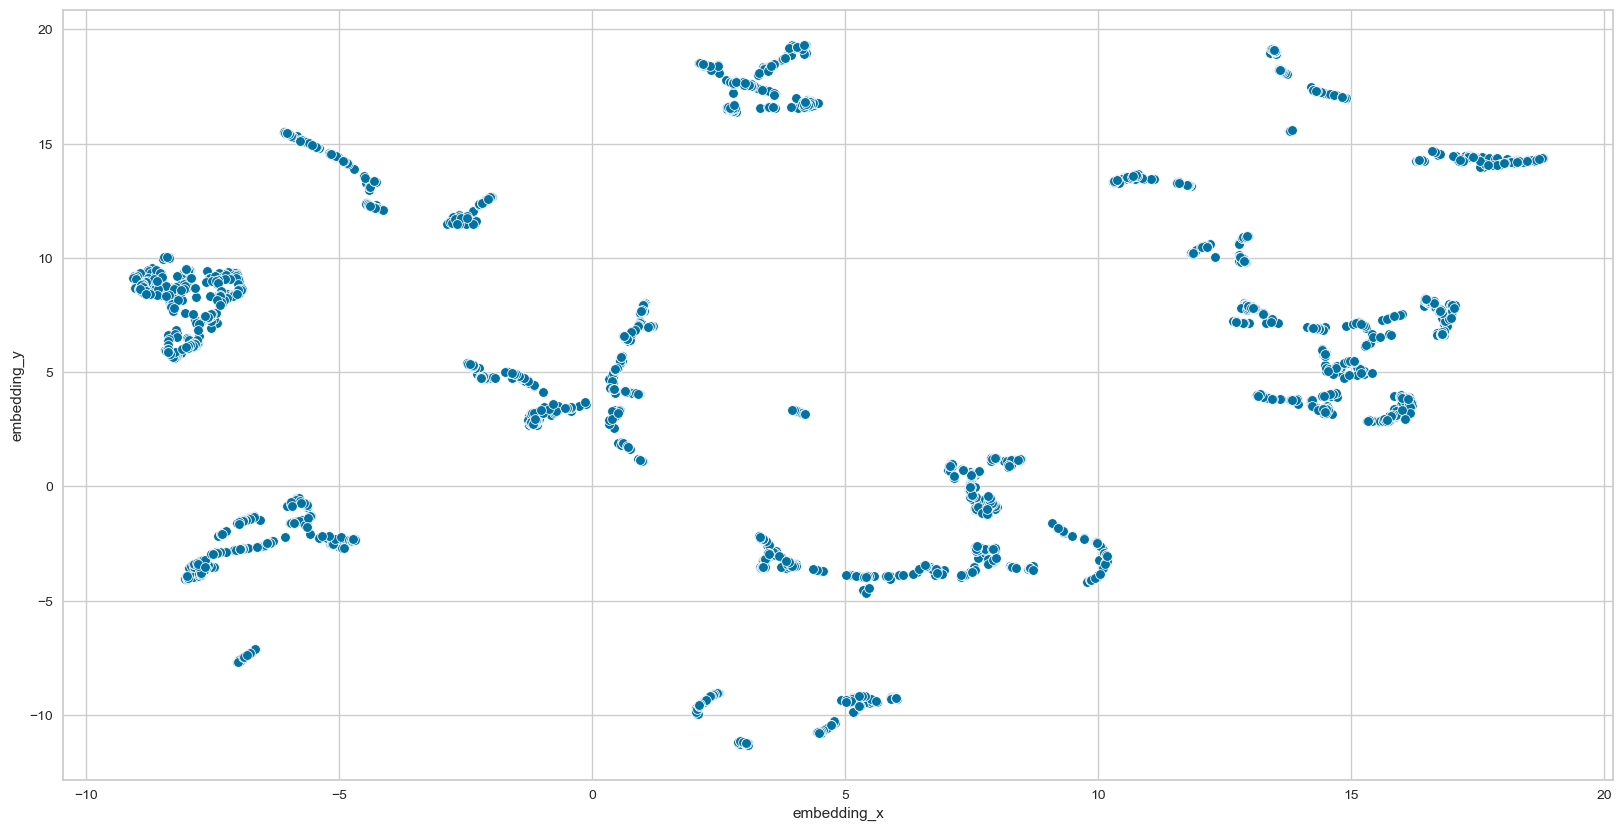

In [168]:
#instantiate a space reducer
reducer = umap.UMAP(random_state=SEED)

#create a embedding space
embedding_rf = reducer.fit_transform(df_leaf)

df_tree = pd.DataFrame(embedding_rf, columns=['embedding_x','embedding_y'])


#plot high dimensional space into 2d 
plt.figure(figsize=(20,10))
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tree);

# 6. Data Preparation

- Padronização (Standardization) => premissa que dados vieram de uma distribuição normal -> Coloca os dados de media 0 e 1 desvio padrao (caso haja outliers = RobustScaler)
- Normalização (Rescaling) => Sem premissa de normalidade -> coloca os dados entre 0-1 (MinMaxScaler) 

- Teste de Normalidade = QQ plot
- Test KS = Kolgomorov Smirnoff (Teste Hipotese) p-value>0.5  distribuição normal / p-value<0.5 distribuição não-normal
- Distribuição normal sem outliers => StandardScaler (mean e std)
- Distrubuição normal com outliers => RobustScaler (quartis)
- Distribuição não-normal => MinMaxScaler

In [169]:
df6 = df5.copy()

In [170]:
#removing customer_id
cols = ['gross_revenue', 'qty_invoices', 'qty_items_purchased', 'products_variety', 'avg_ticket', 'recency_days', 'avg_recency_days', 'frequency_days', 'total_return', 'avg_basket_size', 'avg_variety_basket'] 

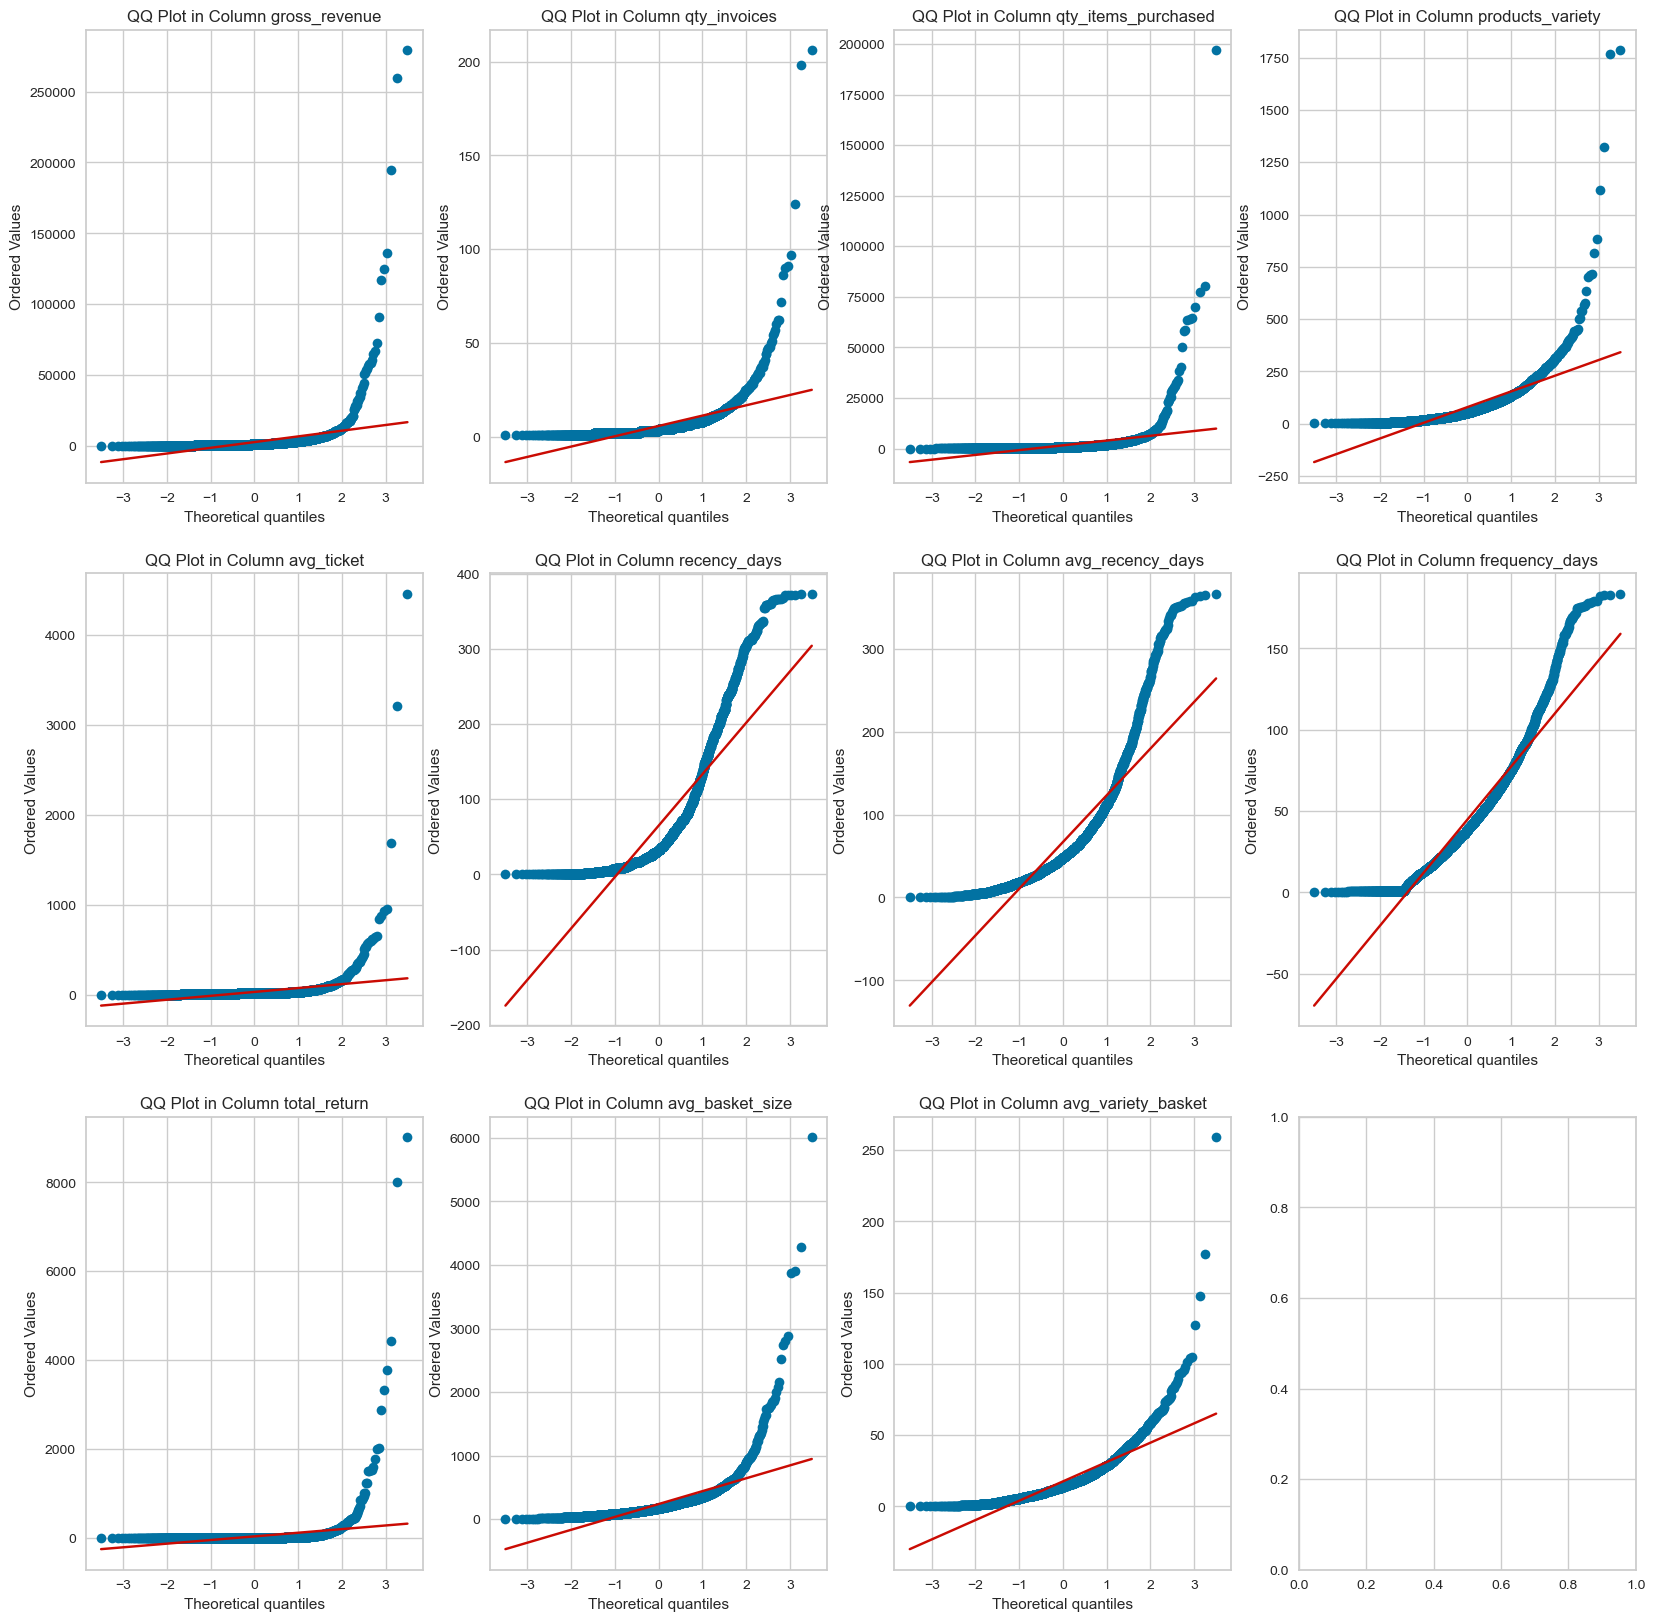

In [171]:
from scipy import stats

plt.subplots(3,4,figsize=(20,20))
for idx,col in enumerate(cols):

    stats.probplot(df6[col],plot=plt.subplot(3,4,idx+1));
    plt.title('QQ Plot in Column {}'.format(col))

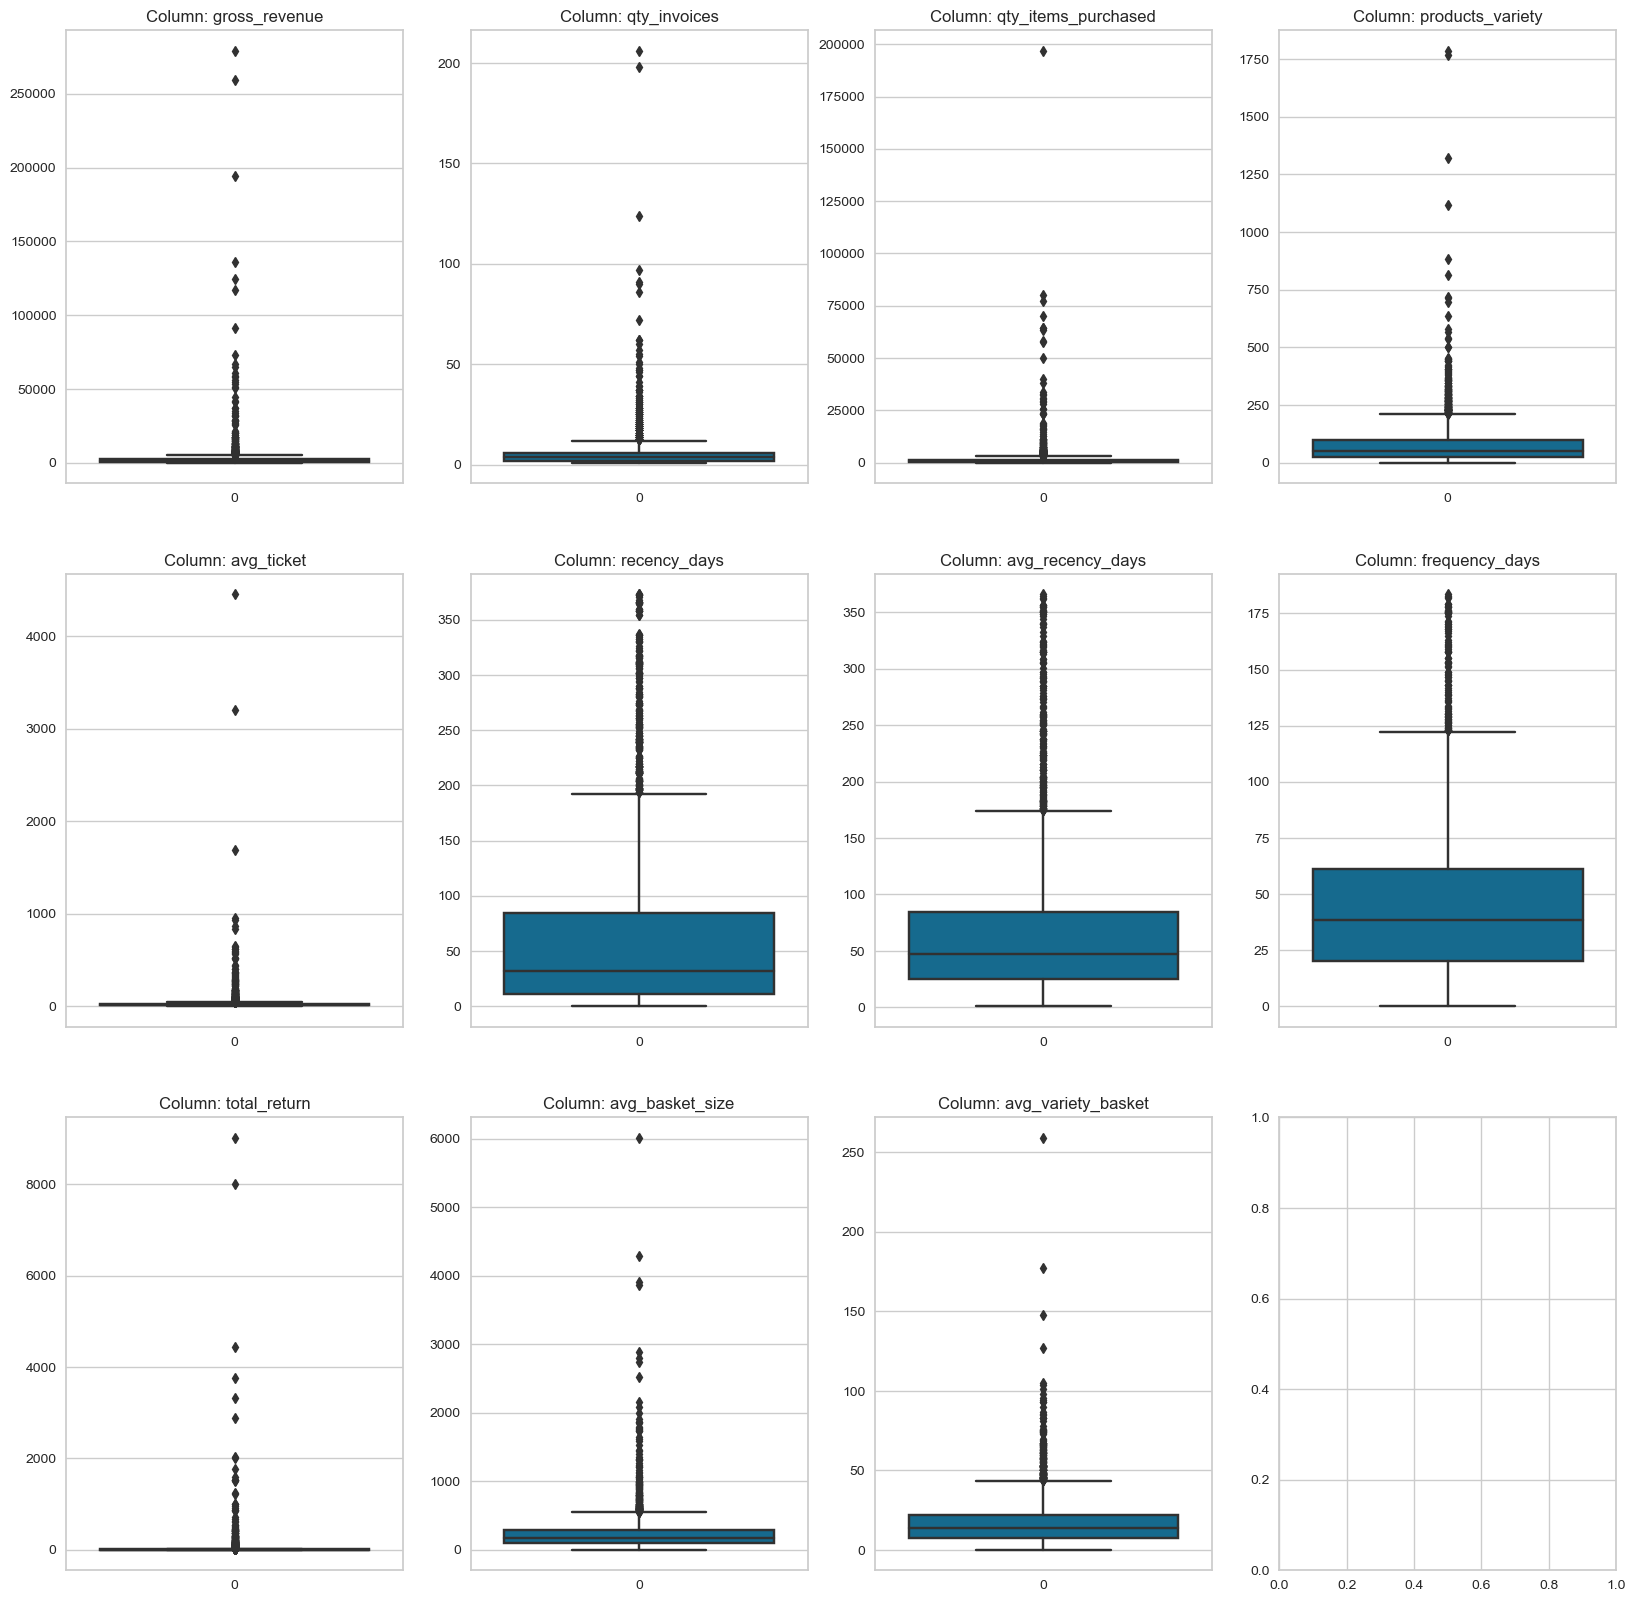

In [172]:
plt.subplots(3,4,figsize=(20,20))
for idx,col in enumerate(cols):
    plt.subplot(3,4,idx+1)
    sns.boxplot(df6[col])
    plt.title('Column: {}'.format(col))

In [173]:
#scaler = MinMaxScaler() # not normal distributed parameters with extreme values => we will use MinMax
#scaler = RobustScaler()
#scaler = StandardScaler()

#cols = ['gross_revenue', 'qty_invoices', 'qty_items_purchased', 'products_variety', 'avg_ticket', 'recency_days', 'avg_recency_days', 'frequency_days', 'total_return', 'avg_basket_size', 'avg_variety_basket'] 
# for col in cols:
#     df6[col] = scaler.fit_transform(df6[[col]])

#we will apply scaler one by one to inverse_transform later
scaler_gv = MinMaxScaler()
df6['gross_revenue'] = scaler_gv.fit_transform(df6[['gross_revenue']])

scaler_qtinv = MinMaxScaler()
df6['qty_invoices'] = scaler_qtinv.fit_transform(df6[['qty_invoices']])

scaler_qtip = MinMaxScaler()
df6['qty_items_purchased'] = scaler_qtip.fit_transform(df6[['qty_items_purchased']])

scaler_pv = MinMaxScaler()
df6['products_variety'] = scaler_pv.fit_transform(df6[['products_variety']])

scaler_avgtkt = MinMaxScaler()
df6['avg_ticket'] = scaler_avgtkt.fit_transform(df6[['avg_ticket']])

scaler_rd = MinMaxScaler()
df6['recency_days'] = scaler_rd.fit_transform(df6[['recency_days']])

scaler_avgrd = MinMaxScaler()
df6['avg_recency_days'] = scaler_avgrd.fit_transform(df6[['avg_recency_days']])

scaler_fd = MinMaxScaler()
df6['frequency_days'] = scaler_fd.fit_transform(df6[['frequency_days']])

scaler_tr = MinMaxScaler()
df6['total_return'] = scaler_tr.fit_transform(df6[['total_return']])

scaler_avgbs = MinMaxScaler()
df6['avg_basket_size'] = scaler_avgbs.fit_transform(df6[['avg_basket_size']])

scaler_avgvar = MinMaxScaler()
df6['avg_variety_basket'] = scaler_avgvar.fit_transform(df6[['avg_variety_basket']])

# 7. Feature Selection

In [174]:
df7 = df6.copy()

#In this cycle we will pick manually the features according to business knowledge to build clusters in the end of cycle (the averages features created will be dropped for now) => we will study other techniques to non-supervised problems
#If changes here, must be changed on section 10.3 Cluster Profile
cols_selected = ['gross_revenue','recency_days','products_variety', 'frequency_days', 'total_return']

#manual selection
df7 = df7[cols_selected]

# 8. HP Fine Tuning (cluster definition)

In [175]:
#X = df7.copy()      #feature space
X = df_tree.copy()   #embedding space

## 8.1 WSS (Within Cluster Sum of Squares)

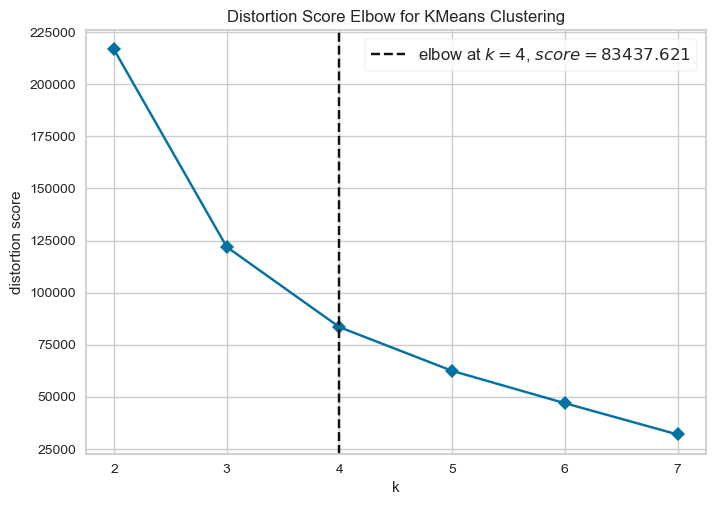

In [176]:
clusters = [2, 3, 4, 5, 6, 7]

kmeans = KElbowVisualizer (KMeans(), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

## 8.2 Sillhouette Score 

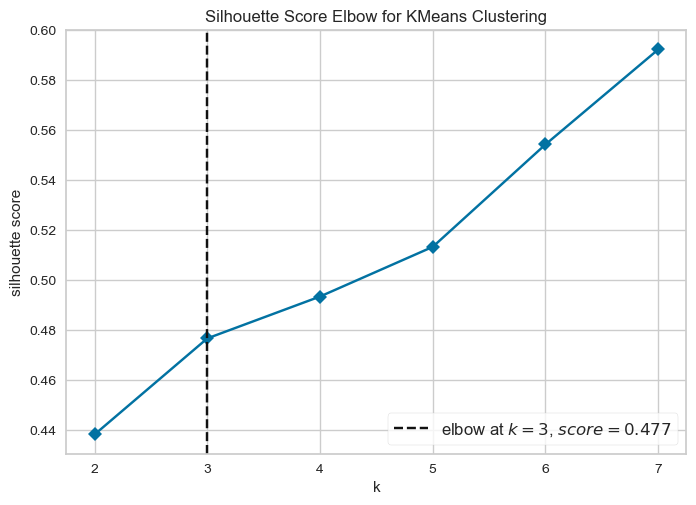

In [177]:
silhoutte = KElbowVisualizer(KMeans(), k=clusters, metric='silhouette',timings=False)
silhoutte.fit(X)
silhoutte.show();

## 8.1 Silhouette Analysis

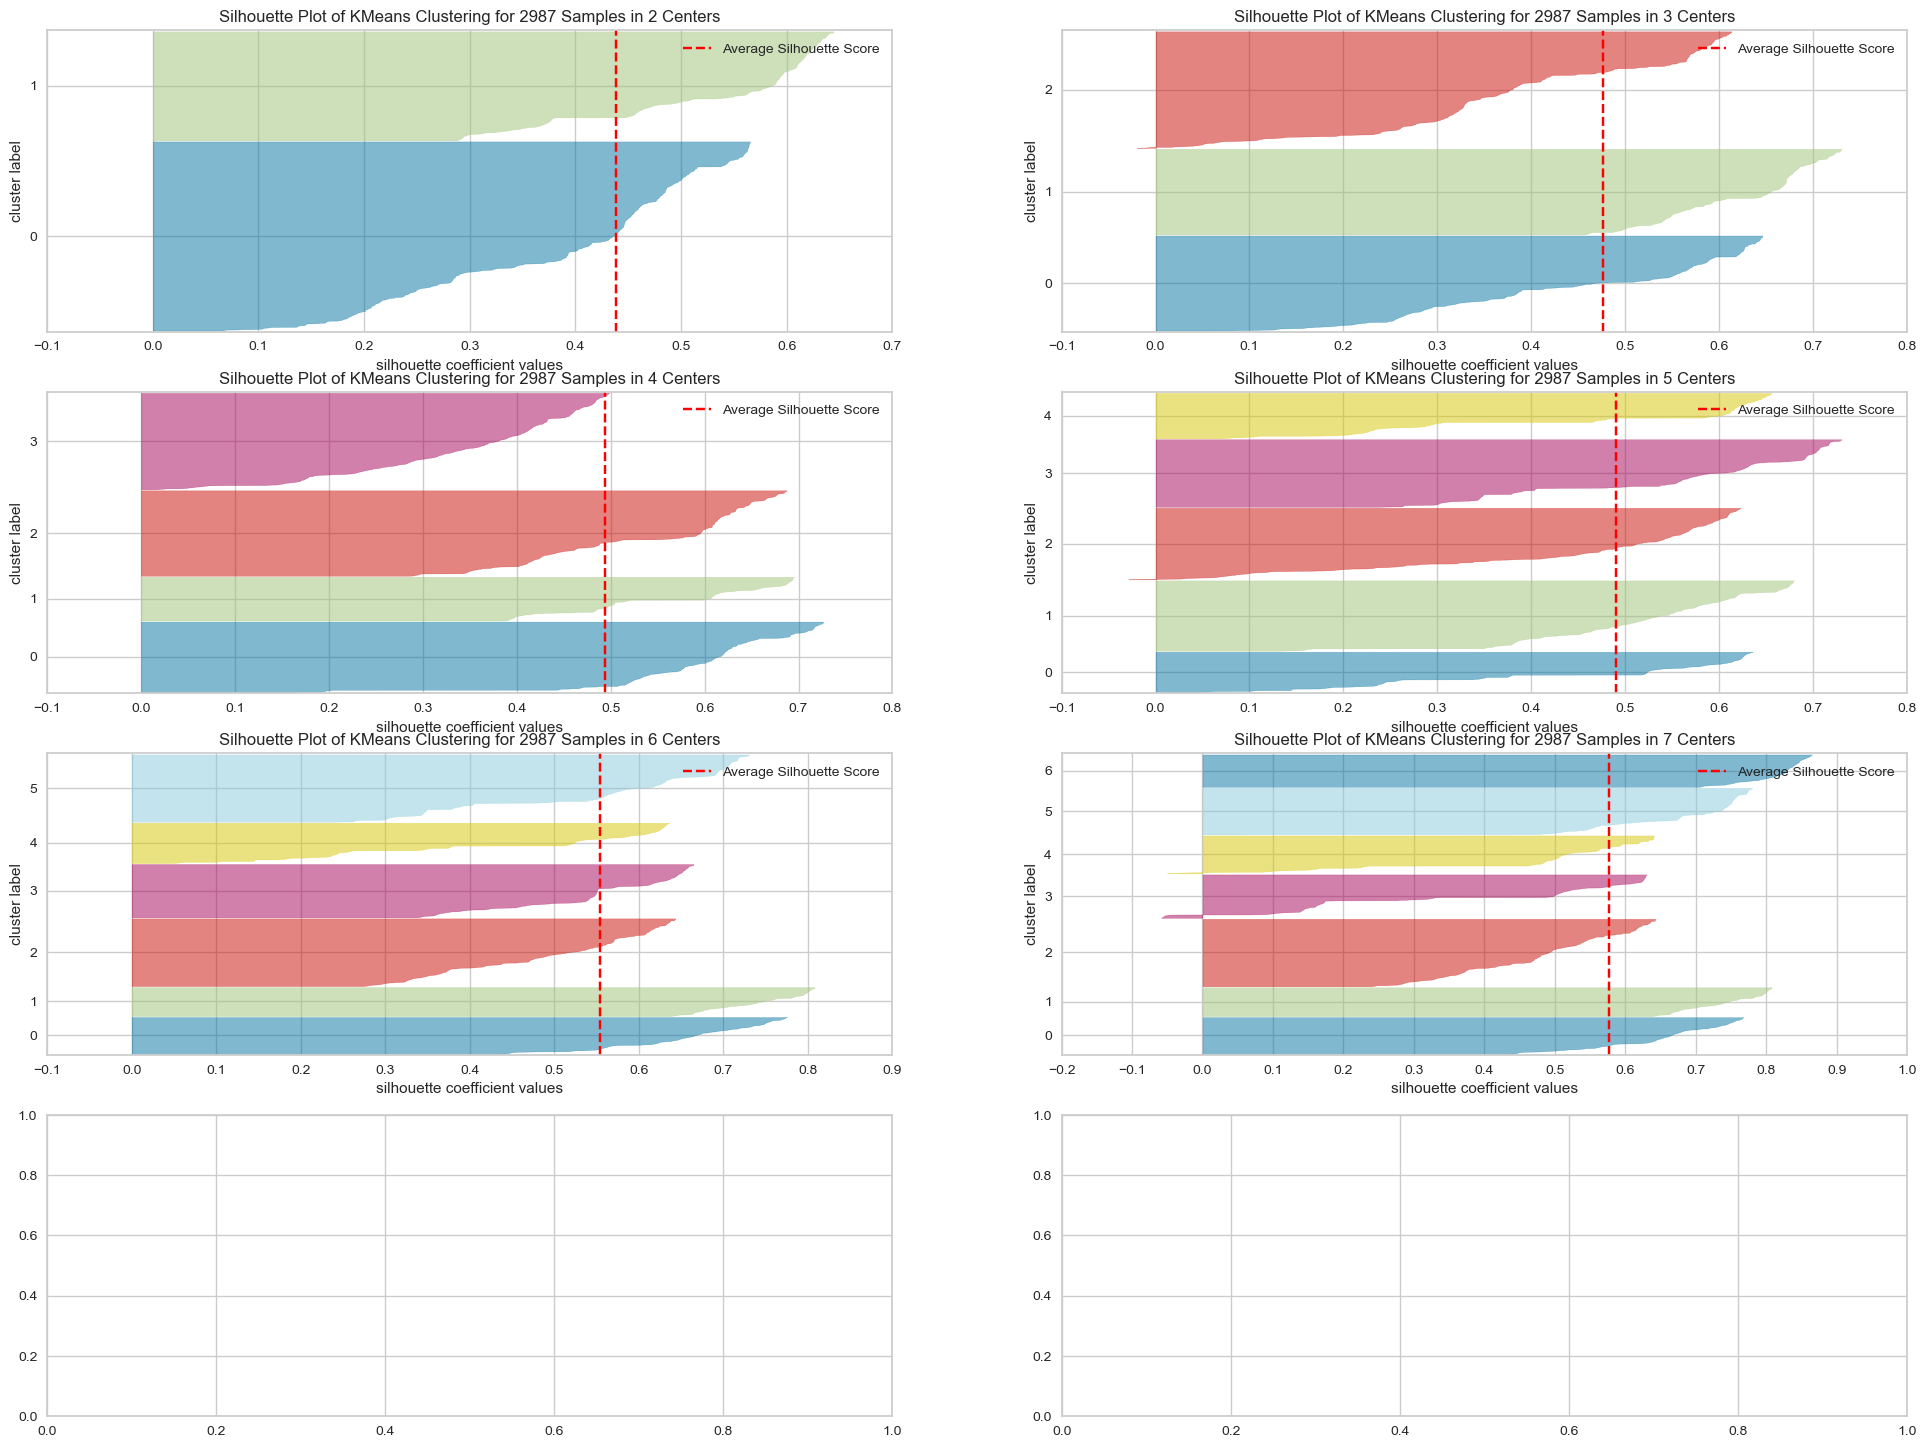

In [178]:
fig,ax = plt.subplots(4,2,figsize=(24,18))

for k in clusters:
    
    km = KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=SEED)
    
    #trick to multiplots
    q,mod = divmod(k,2)
    
    viz = SilhouetteVisualizer(km, colors='yellowbrick',ax=ax[q-1][mod] )
    viz.fit(X)
    viz.finalize()

# 9. ML Modeling

In [179]:
clusters = np.arange(2,25,1) #embbeding space
#clusters = [2,3,4,5,6,7]

## 9.1 K-Means

In [180]:
kmeans_sil_list=[]

for k in clusters:

    #model definition
    kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=SEED)

    #model training
    kmeans.fit(X)

    #clustering
    labels = kmeans.predict(X)

    #performance

    sil_score = metrics.silhouette_score(X, labels, metric='euclidean')
    kmeans_sil_list.append(sil_score)

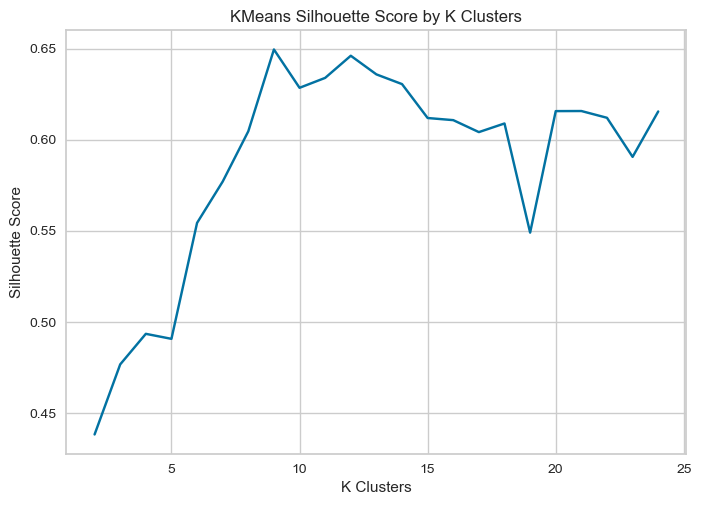

In [181]:
plt.plot(clusters, kmeans_sil_list)
plt.xlabel('K Clusters')
plt.ylabel('Silhouette Score')
plt.title('KMeans Silhouette Score by K Clusters');

## 9.2 Gaussian Mixture Model

In [182]:
gmm_sil_list = []

for k in clusters:

    #model definition
    gmm = GaussianMixture(n_components=k)

    #model training
    gmm.fit(X)

    #model clustering

    labels = gmm.predict(X)

    #model performance

    sil_score = metrics.silhouette_score(X, labels, metric='euclidean')
    gmm_sil_list.append(sil_score)


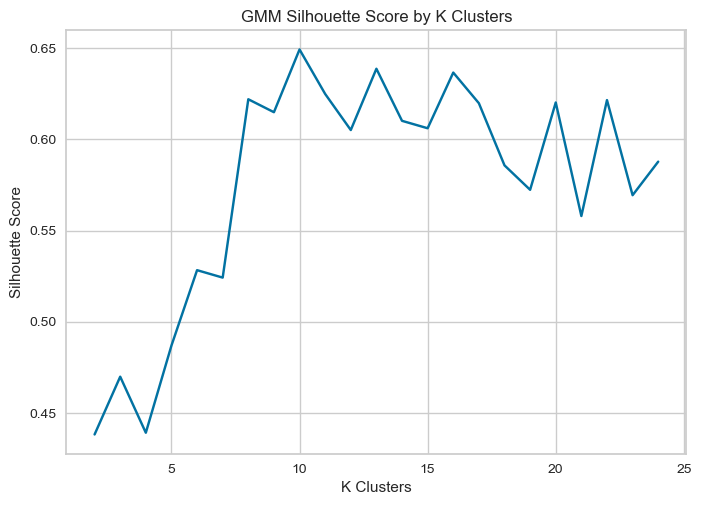

In [183]:
plt.plot(clusters, gmm_sil_list)
plt.xlabel('K Clusters')
plt.ylabel('Silhouette Score')
plt.title('GMM Silhouette Score by K Clusters');

## 9.3 Hierarchical Clustering

In [184]:
hc_sil_list = []

for k in clusters:
    # model definition and training
    h_cluster = hierarchy.linkage(X, 'ward')

    # model predict
    labels = hierarchy.fcluster(h_cluster, k, criterion='maxclust')

    # model performance
    sil_score = metrics.silhouette_score(X, labels, metric='euclidean')
    hc_sil_list.append(sil_score)

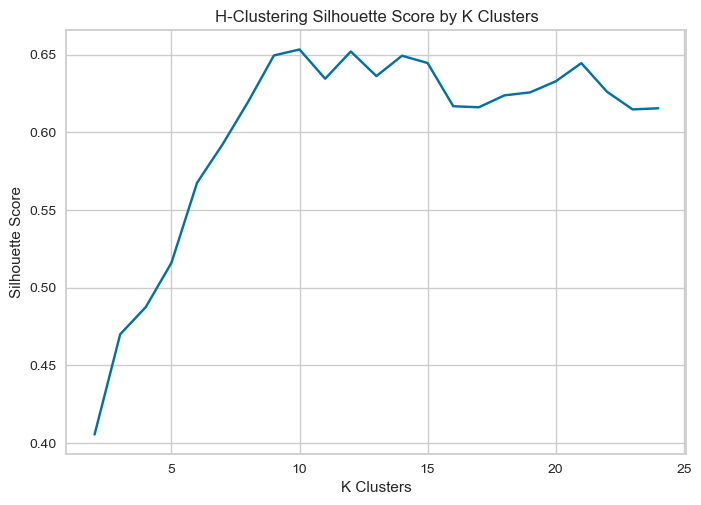

In [185]:
plt.plot(clusters, hc_sil_list)
plt.xlabel('K Clusters')
plt.ylabel('Silhouette Score')
plt.title('H-Clustering Silhouette Score by K Clusters');

In [186]:
#plotting dendrogram
# plt.figure(figsize=(30,12))
# hierarchy.dendrogram(h_cluster, leaf_rotation=90, leaf_font_size=8, truncate_mode='lastp', p=12, show_contracted=True)
# plt.plot();

## 9.4 DBSCAN

In [187]:
#we will set manually, but can be improved using NearestNeighbors algo

#eps_list = [0.1, 0.5, 0.10, 0.5, 0.8]          #feature space
eps_list = [20, 5, 10, 15, 20]                  #embbeding space
min_samples_list = [20, 40, 60, 80, 100]

db_list=[]
clusters_db=[]


for eps in eps_list:

    for min_samples in min_samples_list:

        # model definition
        db = DBSCAN(eps=eps,min_samples=min_samples)
        
        # model training and prediction
        labels = db.fit_predict(X)
        
        if len(np.unique(labels)) <= 1:
            print('DBSCAN for eps={} / min_samples={} resulted in only noise'.format(eps,min_samples))
            db_list.append(0)
            clusters_db.append(0)
            continue
        
        # model performance
        sil_score = metrics.silhouette_score(X, labels, metric='euclidean')
        
        print('EPS={}, MIN_SAMPLES={}, SCORE={}, CLUSTERS={}'.format(eps,min_samples,sil_score,len(np.unique(labels))))
        
        db_list.append(sil_score)
        clusters_db.append(len(np.unique(labels)))

dbscan_scores = pd.DataFrame({'Sillhouete Score':db_list, 'N Clusters':clusters_db})

DBSCAN for eps=20 / min_samples=20 resulted in only noise
DBSCAN for eps=20 / min_samples=40 resulted in only noise
DBSCAN for eps=20 / min_samples=60 resulted in only noise
DBSCAN for eps=20 / min_samples=80 resulted in only noise
DBSCAN for eps=20 / min_samples=100 resulted in only noise
EPS=5, MIN_SAMPLES=20, SCORE=0.3036026060581207, CLUSTERS=4
EPS=5, MIN_SAMPLES=40, SCORE=0.3036026060581207, CLUSTERS=4
EPS=5, MIN_SAMPLES=60, SCORE=0.3036026060581207, CLUSTERS=4
EPS=5, MIN_SAMPLES=80, SCORE=0.3036026060581207, CLUSTERS=4
EPS=5, MIN_SAMPLES=100, SCORE=0.3036026060581207, CLUSTERS=4
DBSCAN for eps=10 / min_samples=20 resulted in only noise
DBSCAN for eps=10 / min_samples=40 resulted in only noise
DBSCAN for eps=10 / min_samples=60 resulted in only noise
DBSCAN for eps=10 / min_samples=80 resulted in only noise
DBSCAN for eps=10 / min_samples=100 resulted in only noise
DBSCAN for eps=15 / min_samples=20 resulted in only noise
DBSCAN for eps=15 / min_samples=40 resulted in only noise
D

In [188]:
dbscan_scores.style.highlight_max()

,Sillhouete Score,N Clusters
0,0.000000,0
1,0.000000,0
2,0.000000,0
3,0.000000,0
4,0.000000,0
5,0.303603,4
6,0.303603,4
7,0.303603,4
8,0.303603,4
9,0.303603,4


In [189]:
#plot_sillhouete_n_clusters(X, KMeans, 'KMeans', [2, 3, 4, 5, 6, 7])

## 9.5 Results

In [190]:
# Silhouette Score Matrix to many clusters

df_results = pd.DataFrame({'KMeans':kmeans_sil_list, 
                           'GMM': gmm_sil_list, 
                           'H-Clustering':hc_sil_list,
                           #'DBSCAN':db_sil_list
                           }).T
df_results.columns = clusters

df_results.style.highlight_max(color='lightgreen',axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.438235,0.476697,0.493464,0.490712,0.554336,0.577017,0.604621,0.649512,0.628476,0.633919,0.646071,0.635841,0.630511,0.611898,0.610731,0.604166,0.608903,0.549010,0.615684,0.615734,0.612020,0.590572,0.615492
GMM,0.438235,0.469910,0.439186,0.486952,0.528301,0.524220,0.621989,0.614887,0.649277,0.624899,0.605113,0.638713,0.610163,0.606090,0.636606,0.619810,0.585753,0.572348,0.620211,0.557980,0.621524,0.569396,0.587784
H-Clustering,0.405371,0.469910,0.487475,0.515951,0.567504,0.592350,0.619837,0.649512,0.653355,0.634521,0.652058,0.636213,0.649319,0.644615,0.616793,0.616129,0.623803,0.625726,0.632848,0.644541,0.626138,0.614750,0.615477


## 9.6 Final Model

In [201]:
# cluster number definition
k = 10 #embedding space

# model definition and training - H-Clustering
h_cluster = hierarchy.linkage(X, 'ward')

# model predict
labels = hierarchy.fcluster(h_cluster, k, criterion='maxclust')

#model performance
print('Silhouette Score: {}'.format(metrics.silhouette_score(X, labels, metric='euclidean' )))

Silhouette Score: 0.6533552408218384


# 10. Cluster Analysis

In [202]:
df_viz = X.copy()

#cluster attribution
df_viz['cluster'] = labels

## 10.1 Visual Inspection

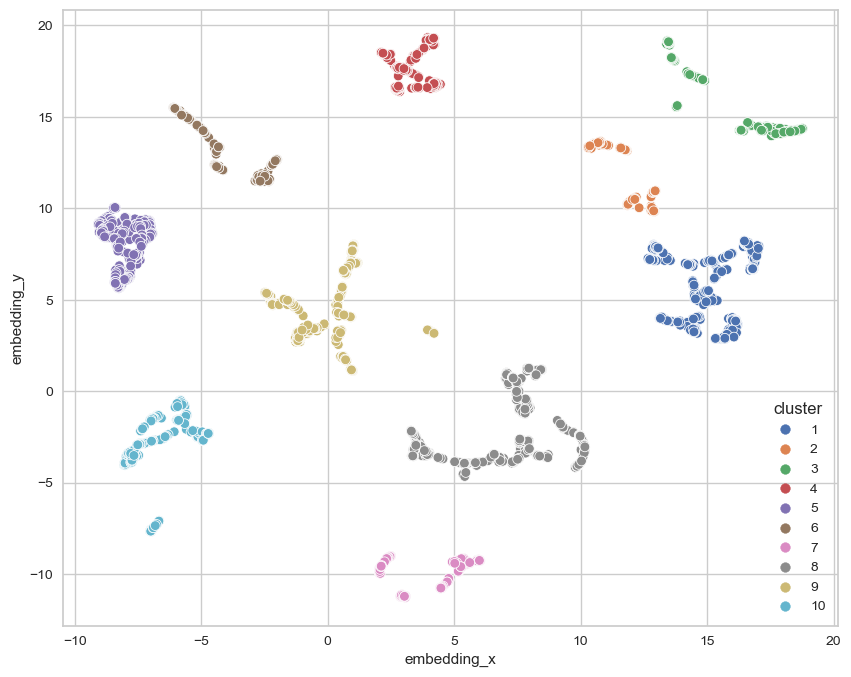

In [210]:
#plot high dimensional space into 2d 
plt.figure(figsize=(10,8))
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', palette='deep', data=df_viz);

## 10.3 Cluster Profile

In [211]:
df10 = df5[cols_selected]
df10['customer_id'] = df5['customer_id']
df10['cluster'] = labels

In [212]:
#Number of Customers
df_cluster = df10[['customer_id', 'cluster']].groupby('cluster').count().reset_index().rename(columns={'customer_id':'qty_customers'})
df_cluster['perc_customers'] = (df_cluster['qty_customers'] / df_cluster['qty_customers'].sum())*100

# Average Gross Revenue
df_gr = df10[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'gross_revenue':'avg_revenue'})
df_cluster = pd.merge(df_cluster,df_gr, on='cluster', how='inner')
 
#Average Recency
df_rec = df10[['recency_days', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'recency_days':'avg_recency'})
df_cluster = pd.merge(df_cluster,df_rec, on='cluster', how='inner')

# Average Products Variety
df_var = df10[['products_variety', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'products_variety':'avg_variety'})
df_cluster = pd.merge(df_cluster,df_var, on='cluster', how='inner')

# Average Frequency
df_fre = df10[['frequency_days', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'frequency_days':'avg_frequency'})
df_cluster = pd.merge(df_cluster,df_fre, on='cluster', how='inner') 

#Average Total Return
df_ret = df10[['total_return', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'total_return':'avg_returns'})
df_cluster = pd.merge(df_cluster,df_ret, on='cluster', how='inner') 

df_cluster.sort_values(by='avg_revenue', ascending=False)

,cluster,qty_customers,perc_customers,avg_revenue,avg_recency,avg_variety,avg_frequency,avg_returns
2,3,236,7.900904,12807.126356,15.936441,281.444915,24.299431,273.838983
0,1,472,15.801808,2871.166102,41.031780,115.288136,43.710487,22.713983
1,2,153,5.122196,2833.316797,32.065359,192.843137,49.914928,3.581699
6,7,182,6.093070,2215.809451,8.500000,70.247253,43.600436,4.615385
8,9,373,12.487446,2189.275308,96.088472,47.533512,47.485226,9.278820
7,8,505,16.906595,1997.170356,81.885149,62.554455,47.241720,41.922772
9,10,294,9.842651,1363.225034,8.544218,27.816327,55.304192,1.421769
4,5,330,11.047874,974.389121,63.603030,21.348485,25.188327,1.924242
3,4,231,7.733512,668.768745,60.558442,22.645022,91.828139,1.337662
5,6,211,7.063944,390.498104,233.876777,14.829384,19.262480,2.554502


## Clusters Reports - Based on Embedding Space - Silhouette Score = 0.65 (H-Clustering)


### Cluster 01 (Insiders Eligible):
        - Customers Quantity: 236 customers (7.9% of total)
        - Average Revenue: $ 12807
        - Average Recency: 15 days ago
        - Average Products Variety: 281 products purchased
        - Average Frequency: Every 24 days
        - Average Returns: 273 units

### Cluster 02:
        - Customers Quantity: 472 customers (15.8% of total) 
        - Average Revenue: $ 2871
        - Average Recency: 41 days ago
        - Average Products Variety: 115 products purchased
        - Average Frequency: 43 days
        - Average Returns: 22 units

### Cluster 03: 
        - Customers Quantity: 153 customers (5.1% of total) 
        - Average Revenue: $ 2883 
        - Average Recency: 32 days ago
        - Average Products Variety: 192 products purchased
        - Average Frequency: 49 days
        - Average Returns: 3 units

### Cluster 04:
        - Customers Quantity: 182 customers (15.8% of total) 
        - Average Revenue: $ 2215
        - Average Recency: 8 days ago
        - Average Products Variety: 70 products purchased
        - Average Frequency: 43 days
        - Average Returns: 4 units


### Cluster 05: 
        - Customers Quantity: 373 customers (12.4% of total) 
        - Average Revenue: $ 2189
        - Average Recency: 96 days ago
        - Average Products Variety: 47 products purchased
        - Average Frequency: 47 days
        - Average Returns: 9 units
        
### Cluster 06:
        - Customers Quantity: 505 customers (16.9% of total) 
        - Average Revenue: $ 1997
        - Average Recency: 81 days ago
        - Average Products Variety: 62 products purchased
        - Average Frequency: 47 days
        - Average Returns: 41 units
        
### Cluster 07: 
        - Customers Quantity: 294 customers (9.8% of total) 
        - Average Revenue: $ 1363
        - Average Recency: 8 days ago
        - Average Products Variety: 27 products purchased
        - Average Frequency: 55 days
        - Average Returns: 1 units
        
### Cluster 08: 
        - Customers Quantity: 330 customers (11% of total) 
        - Average Revenue: $ 974
        - Average Recency: 63 days ago
        - Average Products Variety: 21 products purchased
        - Average Frequency: 25 days
        - Average Returns: 1 units
        
### Cluster 09: 
        - Customers Quantity: 231 customers (7.7% of total) 
        - Average Revenue: $ 668
        - Average Recency: 60 days ago
        - Average Products Variety: 22 products purchased
        - Average Frequency: 91 days
        - Average Returns: 1 units
   
### Cluster 10: 
        - Customers Quantity: 211 customers (7% of total) 
        - Average Revenue: $ 390
        - Average Recency: 233 days ago
        - Average Products Variety: 14 products purchased
        - Average Frequency: 19 days
        - Average Returns: 2 units

# 11. Exploratory Data Analysis - Clustering  Focused 

## 11.1 Mindmap Hypothesis

### 11.1.1 Hypothesis Priorization

## 11.2 Hypothesis Validation

## 11.3 Hypothesis Board

# 12. Model Deployment